### Data Preparation

Any trading strategy or ML model starts with some data. For this project we will use [this kaggle dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs), which contains historic daily OHLC data for various securities. So to start we will download this dataset from kaggle. 



The dataset contains many different securities, to narrow it down im just gonna use this list of various historic S&P 500 stocks that I got from a university course.

In [1]:
import pandas as pd
tickers = pd.read_csv('SP Tickers.csv')
tickers = set(tickers['symbol'].tolist())

In [2]:
len(tickers)

773

Currently all the different ticker data is in its own files, so we can load them all individually and combine them into one giant dataframe `stock_df`

In [3]:
import os
import pandas as pd
from pandas.errors import EmptyDataError

dataframes = []
directory = os.path.join(os.getcwd() + '/Stocks')

for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        ticker = filename.replace('.us.txt', '').upper()
        file_path = os.path.join(directory, filename)

        if ticker not in tickers: # if the ticker isnt in our list, ignore it
          continue

        try:
            df = pd.read_csv(file_path)
            df['Ticker'] = ticker
            df.sort_values('Date', inplace=True)
            dataframes.append(df)
        except EmptyDataError: # some of the files have no contents so read_csv throws error
          pass

stock_df = pd.concat(dataframes, ignore_index=True)

stock_df['Date'] = pd.to_datetime(stock_df['Date'], format='%Y-%m-%d')

The next step is to create some more interesting features and partition the dataset into training and testing periods.

C:\Users\dylan\AppData\Local\Temp\ipykernel_3008\2087222907.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='Count', data=rows_per_year, palette='viridis')


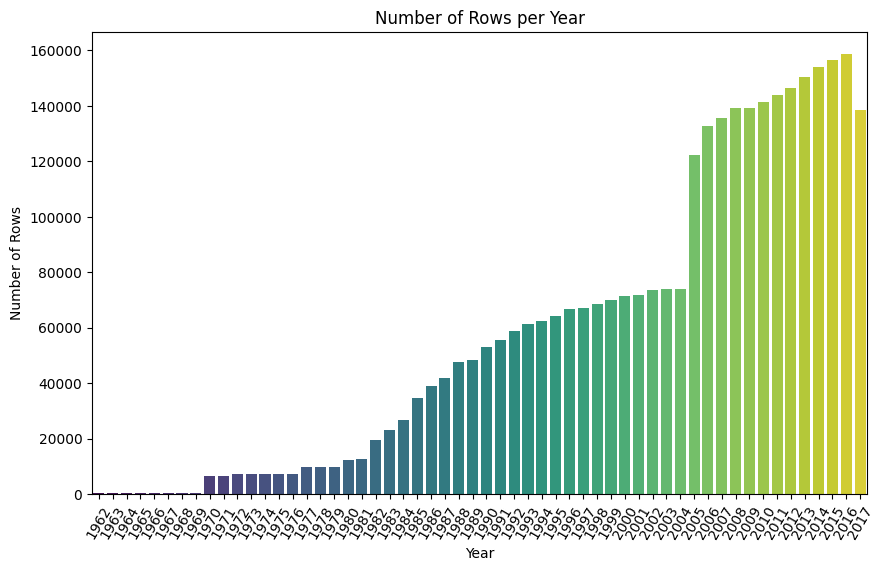

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

df = stock_df.copy()
df['Year'] = df['Date'].dt.year

rows_per_year = df.groupby('Year').size()

rows_per_year = rows_per_year.reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='Count', data=rows_per_year, palette='viridis')
plt.title('Number of Rows per Year')
plt.xlabel('Year')
plt.ylabel('Number of Rows')
plt.xticks(rotation=60)
plt.show()

We can see that there is a lot of data from 2005-2017. For the training set we will use 2010-2012 and for backtesting we will use 2013-2017.

In [5]:
TRAINING_START_DATE = pd.to_datetime("2010-01-01")
TRAINING_END_DATE = pd.to_datetime("2012-12-31")

BACKTEST_START_DATE = pd.to_datetime("2013-01-01")
BACKTEST_END_DATE = pd.to_datetime("2017-12-31")

Now to create some features, I found the [Technical Analysis (TA)](https://github.com/bukosabino/ta) library to be extreamly helpfull for this.

The library contains utilities for generating various volumne, momentum, volatility, and trend indicators from OHLC data. And convieniently you can just add them all with `ta.add_all_ta_features` which is what I will do.

In [6]:
import pandas as pd
import numpy as np
import ta  # Technical analysis library

def get_features_df(stock_df, tickers, start_date, end_date):
    filtered_df = stock_df.loc[
        (stock_df['Ticker'].isin(tickers)) & 
        (stock_df['Date'] >= start_date) & 
        (stock_df['Date'] <= end_date)
    ].copy()

    def process_ticker(ticker_df):
        if len(ticker_df) > 100:
            ticker_df = ta.add_all_ta_features(
                ticker_df, open="Open", high="High", low="Low", close="Close", volume="Volume"
            )
            ticker_df['trading_signal'] = np.where(ticker_df['Close'] >= ticker_df['Open'], 1, -1)
            ticker_df.drop(['trend_psar_up', 'trend_psar_down'], axis=1, inplace=True)
            ticker_df.dropna(inplace=True)
            ticker_df['trading_signal'] = ticker_df['trading_signal'].shift(-1)
            return ticker_df.iloc[:-1]
        
        return pd.DataFrame()
    
    processed_df = filtered_df.groupby('Ticker').apply(process_ticker).reset_index(drop=True)
    
    return processed_df

Note the `trading_signal` column, this indicates whether the price goes up or down on a given day and will be used as the target for our models. The advantage of this is that its relatively simple, however it does not provide a straightforward way to model the risk of a given shift.

In [7]:
from pathlib import Path

train_df_file = Path("train_df.csv")
if train_df_file.is_file():
    train_df = pd.read_csv('train_df.csv')
else:
    train_df = get_features_df(stock_df, tickers, TRAINING_START_DATE, TRAINING_END_DATE)
    train_df.to_csv('train_df.csv')
len(train_df)

384423

Now we have 380,000 rows of data with our 90 ish features.

In [8]:
train_df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,OpenInt,Ticker,volume_adi,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,trading_signal
0,0,2010-04-16,23.991,24.235,23.673,23.810,8547894.0,0.0,A,8.414133e+07,...,1.697406,-0.064102,15.903976,3.240167,12.663809,23.121403,-0.997921,-1.002934,12.694055,-1.0
1,1,2010-04-19,23.856,23.923,23.392,23.735,4245305.0,0.0,A,8.538055e+07,...,1.687949,-0.037828,11.273569,4.846848,6.426721,23.130463,-0.314994,-0.315491,12.339076,1.0
2,2,2010-04-20,23.883,24.619,23.883,24.497,7406726.0,0.0,A,9.033178e+07,...,1.730916,0.171869,11.248949,6.127268,5.121681,23.251580,3.210449,3.159991,15.945665,-1.0
3,3,2010-04-21,24.421,24.564,24.159,24.389,3317955.0,0.0,A,9.078237e+07,...,1.792665,0.246996,6.098052,6.121425,-0.023373,23.367123,-0.440870,-0.441845,15.434495,1.0
4,4,2010-04-22,24.166,24.625,23.810,24.599,4940159.0,0.0,A,9.540733e+07,...,1.872565,0.319602,3.934088,5.683957,-1.749869,23.566643,0.861044,0.857358,16.428436,1.0


Now we are ready to train some models!

### Model Training

First we need to partition the training set into something the model will understand, we can use `sklearn.model_selection.train_test_split` to easily do this. Note that we will exclude the `Date` and `Ticker` columns from the model as it doesnt really make sense to try to learn from these.



In [9]:
from sklearn.model_selection import train_test_split

excluded_features = ['Date', 'Ticker']
features = train_df.drop(columns=excluded_features + ['trading_signal'])
target = train_df['trading_signal']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

#### Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model_random_forest = RandomForestClassifier(n_estimators=100, max_leaf_nodes=32, n_jobs=-1, bootstrap=True)
model_random_forest.fit(X_train, y_train)
y_pred = model_random_forest.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.529817259543474


#### AdaBoost

In [22]:
from sklearn.ensemble import AdaBoostClassifier

model_adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=1.5, algorithm='SAMME')
model_adaboost.fit(X_train, y_train)

y_pred = model_adaboost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.5272289783442804


#### Gradient Boosting

In [12]:
from sklearn.ensemble import HistGradientBoostingClassifier

model_grad_boosting = HistGradientBoostingClassifier(max_leaf_nodes=32, learning_rate=0.2)
model_grad_boosting.fit(X_train, y_train)

y_pred = model_grad_boosting.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.5507055992716394


### Strategy Implementation and Backtest

First we need to create a backtest dataframe with data to feed to the model for the whole backtest

In [13]:
backtest_df_file = Path("backtest_df.csv")
if backtest_df_file.is_file():
    backtest_df = pd.read_csv('backtest_df.csv')
else:
    backtest_df = get_features_df(stock_df, tickers, BACKTEST_START_DATE, BACKTEST_END_DATE)
    backtest_df.to_csv('backtest_df.csv')
len(backtest_df)

711671

By default, the model will simply spit out a -1 or 1 for every security every day. To narrow down the trades we can use a simple trend crossover with the emas that ta created.

In [25]:
def trend_crossover_strategy(df):
    df['crossover_signal'] = 0
    crossover_up = (df['trend_ema_fast'].shift(1) < df['trend_ema_slow'].shift(1)) & (df['trend_ema_fast'] > df['trend_ema_slow'])
    crossover_down = (df['trend_ema_fast'].shift(1) > df['trend_ema_slow'].shift(1)) & (df['trend_ema_fast'] < df['trend_ema_slow'])
    df.loc[crossover_up, 'crossover_signal'] = 1
    df.loc[crossover_down, 'crossover_signal'] = -1
    return df

Now combining the two we can generate signals...

In [74]:
def gen_signals(df, date, model): # Generate trading signals for a give backtest day
    date_df = df.loc[df['Date'] == date].copy()
    date_df['trading_signal'] = 0
    features_df = date_df.drop(columns=excluded_features + ['trading_signal'])
    
    date_df['ensembles_signal'] = model.predict(features_df)
    date_df = trend_crossover_strategy(date_df)
    
    date_df['Signal'] = np.where((date_df['ensembles_signal'] == date_df['crossover_signal']) & (date_df['volatility_atr'] > 1.75), date_df['crossover_signal'], 0)
    
    return date_df[date_df['Signal'] != 0]

And finally we can iterate through all the trading days in the backtest, apply the strategy to generate the trading indicators, and indicate trades. Note that this is a day trading strategy where we Buy/Sell on the Open and Close.

In [83]:
def gen_trades(df, model):
    dataframes = []
    days = sorted(df['Date'].unique())

    # iterate through all the trading days
    for data_day, pred_day in zip(days, days[1:]):
        signals = gen_signals(df, data_day, model)
        # print(pred_day, len(signals))

        pred_day_data = df[df['Date'] == pred_day].set_index('Ticker')

        signals['Buy'] = np.nan
        signals['Sell'] = np.nan

        buy_mask = signals['Signal'] == 1
        sell_mask = signals['Signal'] == -1

        if not pred_day_data.empty:
            valid_buy_tickers = signals.loc[buy_mask, 'Ticker'].isin(pred_day_data.index)
            signals.loc[buy_mask & valid_buy_tickers, 'Buy'] = pred_day_data.loc[signals.loc[buy_mask & valid_buy_tickers, 'Ticker'], 'Open'].values
            signals.loc[buy_mask & valid_buy_tickers, 'Sell'] = pred_day_data.loc[signals.loc[buy_mask & valid_buy_tickers, 'Ticker'], 'Close'].values

            valid_sell_tickers = signals.loc[sell_mask, 'Ticker'].isin(pred_day_data.index)
            signals.loc[sell_mask & valid_sell_tickers, 'Buy'] = pred_day_data.loc[signals.loc[sell_mask & valid_sell_tickers, 'Ticker'], 'Close'].values
            signals.loc[sell_mask & valid_sell_tickers, 'Sell'] = pred_day_data.loc[signals.loc[sell_mask & valid_sell_tickers, 'Ticker'], 'Open'].values


        dataframes.append(signals)
    
    trades_df = pd.concat(dataframes, ignore_index=True)
    return trades_df

In [80]:
def compute_daily_returns(trades_df, initial_capital=100000):
    dates = []
    daily_returns = []
    cumulative_returns = []
    portfolio_values = []

    capital = initial_capital
    portfolio_value = capital
    cum_return = 1

    for date in sorted(trades_df['Date'].unique()):
        daily_trades = trades_df[trades_df['Date'] == date]
        daily_return = 0
        
        if not daily_trades.empty:
            for _, trade in daily_trades.iterrows():
                if trade['Signal'] == 1:
                    buy_price = trade['Buy']
                    sell_price = trade['Sell']
                    profit_loss = sell_price - buy_price
                elif trade['Signal'] == -1:
                    buy_price = trade['Sell']
                    sell_price = trade['Buy']
                    profit_loss = buy_price - sell_price
                else:
                    profit_loss = 0

                daily_return += profit_loss / portfolio_value
                portfolio_value += profit_loss
        
        cum_return *= (1 + daily_return)
        capital = portfolio_value
        
        dates.append(date)
        daily_returns.append(daily_return)
        cumulative_returns.append(cum_return)
        portfolio_values.append(portfolio_value)

    return dates, daily_returns, cumulative_returns, portfolio_values

def compute_metrics(dates, daily_returns, cumulative_returns):
    daily_returns = pd.Series(daily_returns, index=dates)
    cumulative_returns = pd.Series(cumulative_returns, index=dates)

    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

    win_percentage = (daily_returns > 0).sum() / len(daily_returns)

    metrics = {
        'Sharpe Ratio': sharpe_ratio,
        'Win Percentage': win_percentage
    }

    return metrics

def plot_returns(dates, daily_returns, cumulative_returns, portfolio_values):
    plt.figure(figsize=(14, 7))

    plt.subplot(3, 1, 1)
    plt.plot(dates, daily_returns, label='Daily Returns')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title('Daily Returns Over Time')
    plt.grid(True)
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(dates, cumulative_returns, label='Cumulative Returns', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Cumulative Returns Over Time')
    plt.grid(True)
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(dates, portfolio_values, label='Portfolio Value', color='green')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

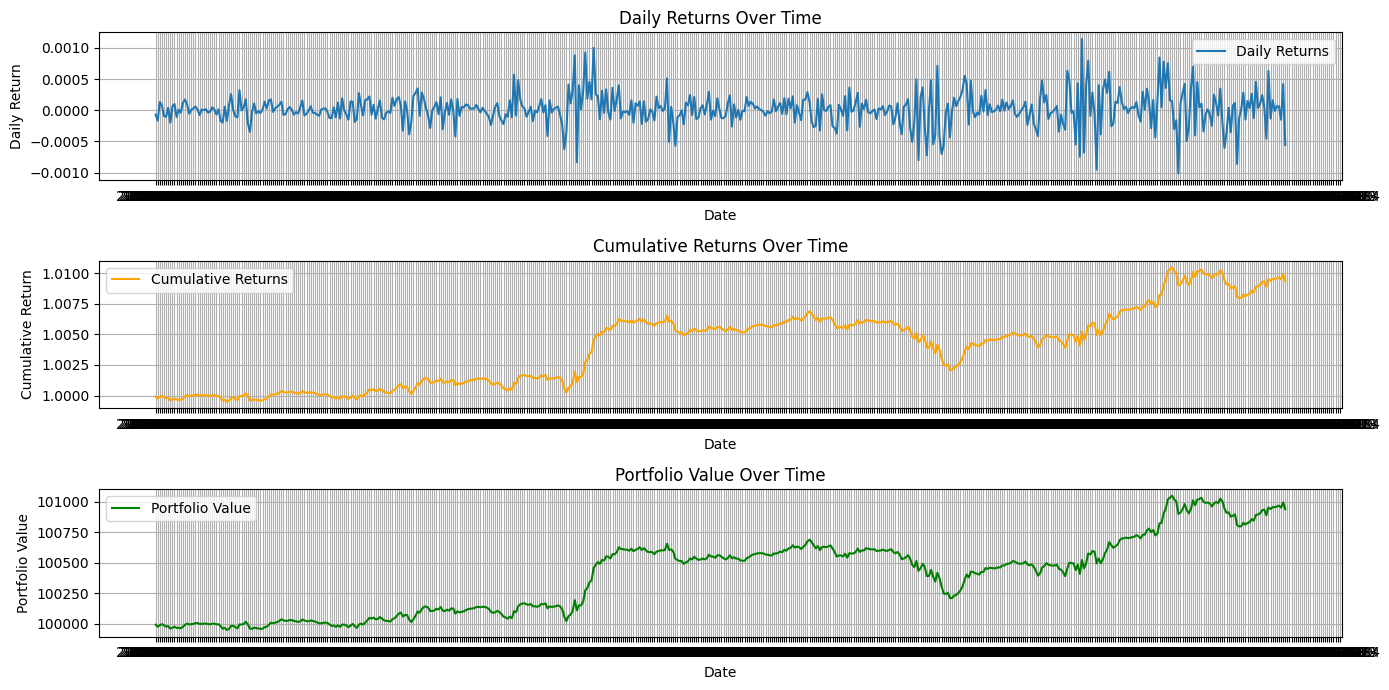

Sharpe Ratio: 1.0750599467988433
Win Percentage: 0.2523850823937554
nan


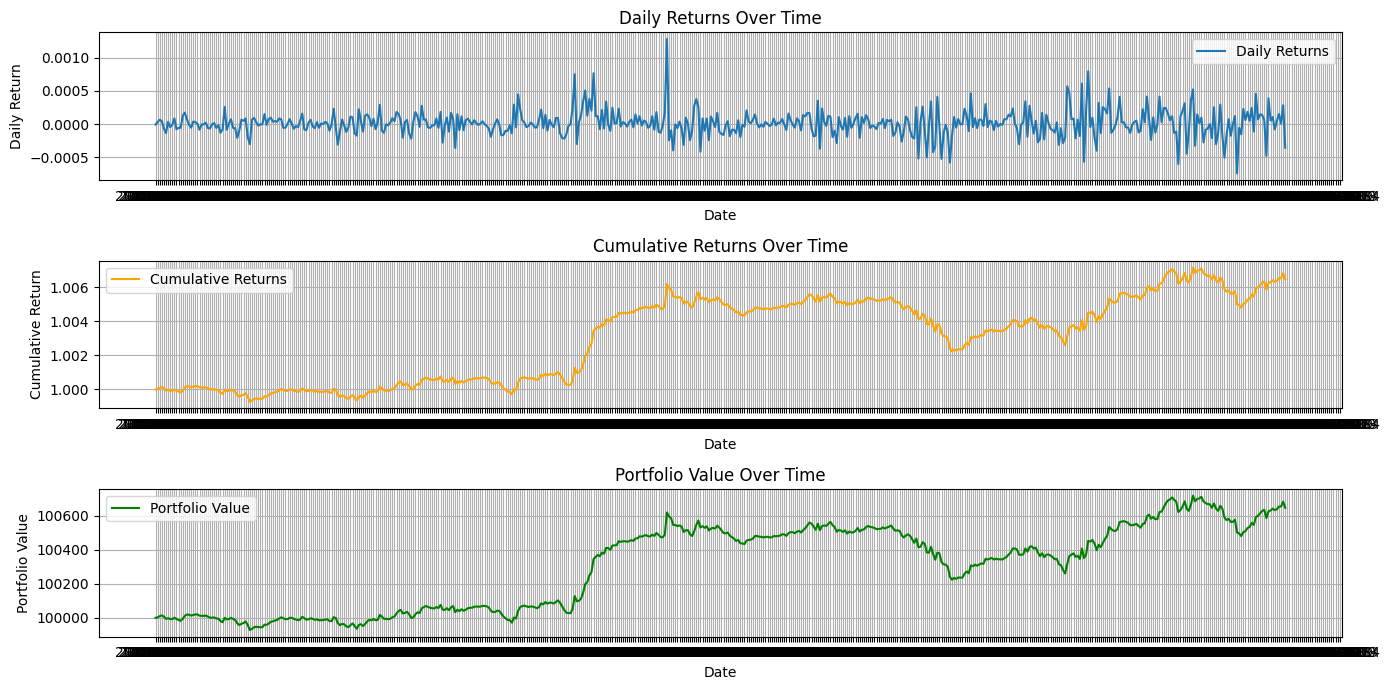

Sharpe Ratio: 0.9963087284943709
Win Percentage: 0.24284475281873374
nan


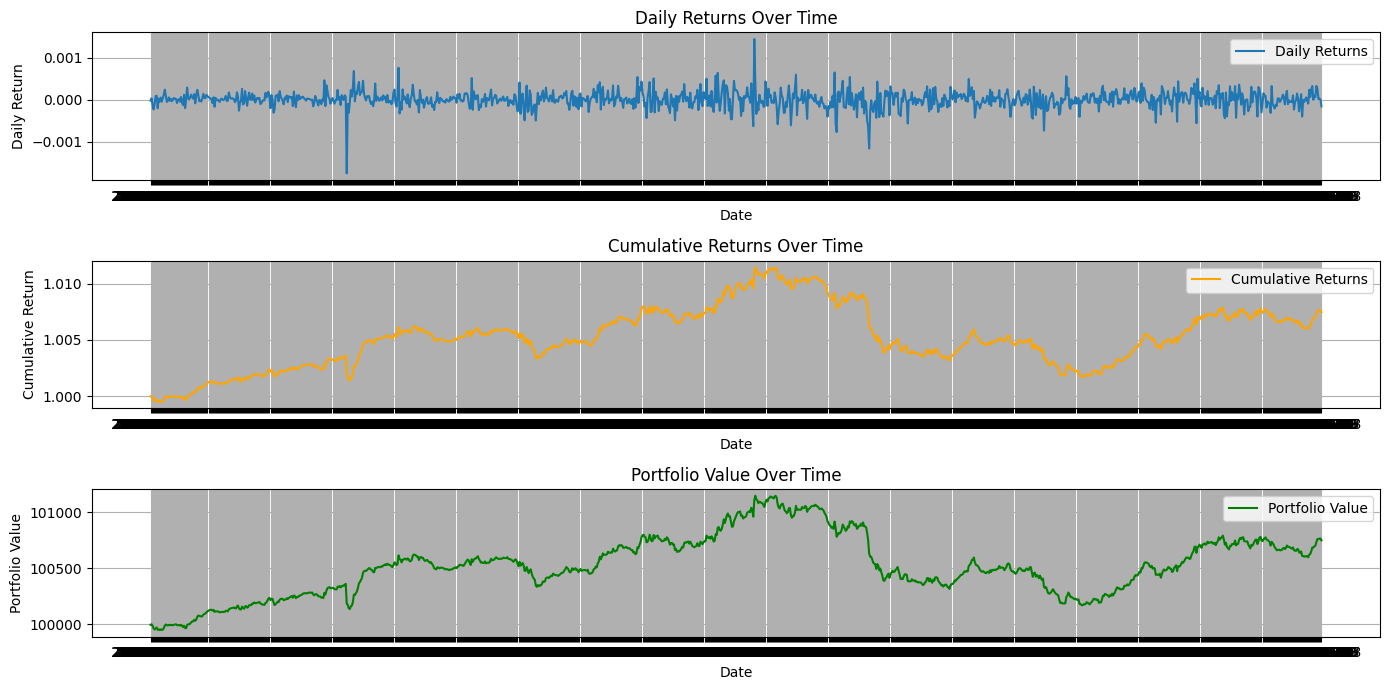

Sharpe Ratio: 0.5142487176448528
Win Percentage: 0.5333911535125759
100748.53749999996


In [88]:
for model in [model_random_forest, model_adaboost, model_grad_boosting]:
    trades_df = gen_trades(backtest_df, model)
    
    dates, daily_returns, cumulative_returns, portfolio_values = compute_daily_returns(trades_df)
    plot_returns(dates, daily_returns, cumulative_returns, portfolio_values)

    metrics = compute_metrics(dates, daily_returns, cumulative_returns)
    for key, value in metrics.items():
        print(f"{key}: {value}")
    print(portfolio_values[-1])